# Time series forcasting of temprature

In [226]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6, 6)

In [227]:
import tensorflow as tf

### Dataset

In [229]:
location = tf.keras.utils.get_file(origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',fname='jena_climate_2009_2016.csv.zip',extract=True)
print(location)

C:\Users\venkatesh lotlikar\.keras\datasets\jena_climate_2009_2016.csv.zip


In [230]:
df = pd.read_csv("jena_climate_2009_2016.csv")
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [231]:
df.shape  # shape of the dataset

(420551, 15)

In [232]:
df.columns   # column names

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

In [233]:
df.isnull().sum()   # checking null values

Date Time          0
p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64

In [234]:
df.describe()   # basic stats about features

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000
mean,989.212776,9.450147,283.492743,4.955854,76.008259,13.576251,9.533756,4.042412,6.022408,9.640223,1216.062748,1.702224,3.056555,174.743738
std,8.358481,8.423365,8.504471,6.730674,16.476175,7.739020,4.184164,4.896851,2.656139,4.235395,39.975208,65.446714,69.016932,86.681693
min,913.600000,-23.010000,250.600000,-25.010000,12.950000,0.950000,0.790000,0.000000,0.500000,0.800000,1059.450000,-9999.000000,-9999.000000,0.000000
25%,984.200000,3.360000,277.430000,0.240000,65.210000,7.780000,6.210000,0.870000,3.920000,6.290000,1187.490000,0.990000,1.760000,124.900000
50%,989.580000,9.420000,283.470000,5.220000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.790000,1.760000,2.960000,198.100000
75%,994.720000,15.470000,289.530000,10.070000,89.400000,17.600000,12.350000,5.300000,7.800000,12.490000,1242.770000,2.860000,4.740000,234.100000
max,1015.350000,37.280000,311.340000,23.110000,100.000000,63.770000,28.320000,46.010000,18.130000,28.820000,1393.540000,28.490000,23.500000,360.000000


## 1. Base model: Moving window average using temprature

<AxesSubplot:>

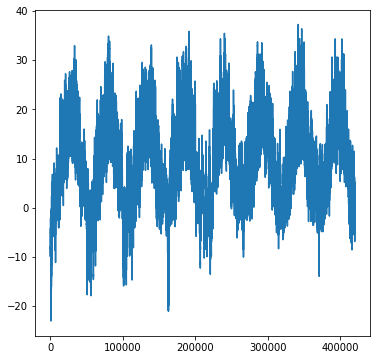

In [235]:
df["T (degC)"].plot()    # distribution of temprature

In [236]:
# prepare the data
df_temp = df["T (degC)"]
df_temp.index = df["Date Time"]
df_temp.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

In [237]:
df_temp.shape

(420551,)

In [238]:
df_temp = df_temp.values
df_temp

array([-8.02, -8.41, -8.51, ..., -3.16, -4.23, -4.82])

In [239]:
train = 350000

# Standardize data: use only train data to standardize to avoid data leakage
df_temp_mean = df_temp[:train].mean()
df_temp_std = df_temp[:train].std() 
df_temp = (df_temp - df_temp_mean)/(df_temp_std)
df_temp

array([-2.02968527, -2.07521719, -2.08689204, ..., -1.46228759,
       -1.58720848, -1.65609009])

In [240]:
df_temp.shape

(420551,)

## Prepare train and text data for MWA

In [241]:
def dataset(df, start_index, end_index, history, target):    
    data_x = []
    labels_y = []
    start_index = start_index + history
    for i in range(start_index, end_index):
        idx = range(i-history, i)
        data_x.append(np.reshape(df[idx], (history, 1)))
        labels_y.append(df[i+target])
    return np.array(data_x), np.array(labels_y)

In [242]:
hist = 50  # number of data points to be reffered from history to make prediction
targ = 0   # point in future to be predicted

In [243]:
# Train data
x_train_temp, y_train_temp = dataset(df_temp, 0, train, hist, targ)
# Test data
x_test_temp, y_test_temp = dataset(df_temp, train, df_temp.shape[0] , hist, targ)

In [244]:
def create_time_steps(length):
    return list(range(-length, 0))

print(create_time_steps(10))

[-10, -9, -8, -7, -6, -5, -4, -3, -2, -1]


In [245]:
# Function for plotting the results

<module 'matplotlib.pyplot' from 'C:\\Users\\venkatesh lotlikar\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

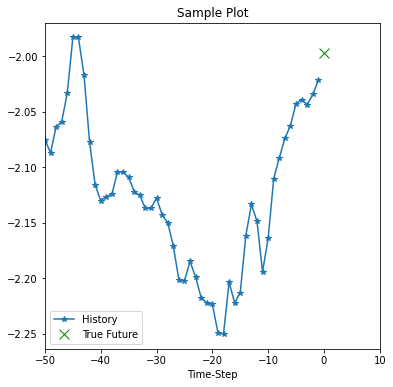

In [246]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['*-', 'gx', 'ro']
    time_steps = create_time_steps(plot_data[0].shape[0])

    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                   label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
        plt.legend()
        plt.xlim([time_steps[0], (future+5)*2])
        plt.xlabel('Time-Step')
    return plt


show_plot([x_train_temp[1], y_train_temp[1]], 0, 'Sample Plot')

In [247]:
def moving_window_avg_model(time_stamp):
    predicted = time_stamp.mean()
    return predicted

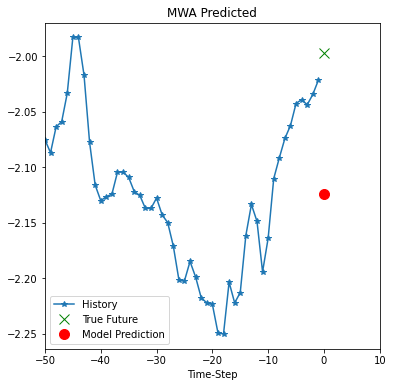

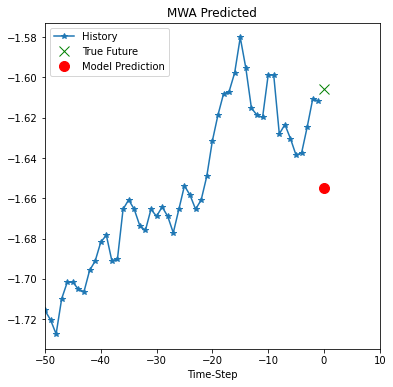

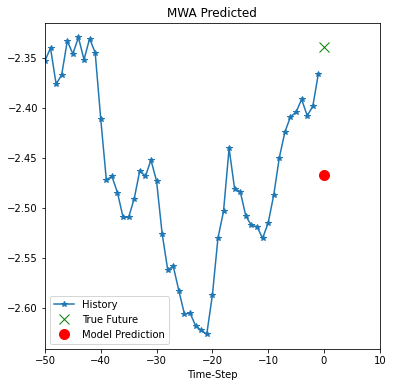

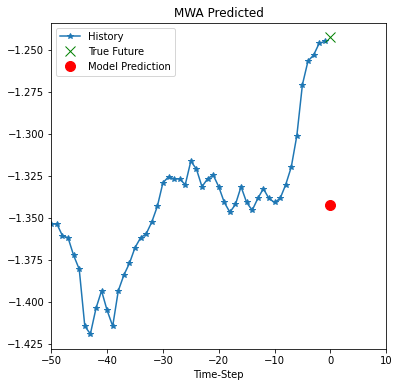

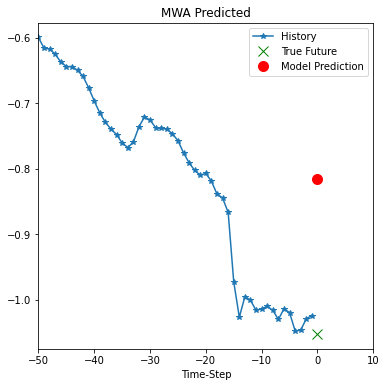

In [248]:
stamps = [1, 100, 1000, 2300, 3400]
for i in stamps:
    plot = show_plot([x_train_temp[i], y_train_temp[i], moving_window_avg_model(x_train_temp[i])], 0,'MWA Predicted')
    plot.show()

## Forcasting using LSTM 

In [250]:
# need to get data in form of repeat dataset to give it as input to LSTM model
batch = 128
shuff = 10000

train_temp_slices =  tf.data.Dataset.from_tensor_slices((x_train_temp, y_train_temp))
train_temp = train_temp_slices.cache().shuffle(shuff).batch(batch).repeat()

test_temp_slices =  tf.data.Dataset.from_tensor_slices((x_test_temp, y_test_temp))
test_temp = train_temp_slices.cache().shuffle(shuff).batch(batch).repeat()

In [251]:
print(train_temp)
print(test_temp)

<RepeatDataset shapes: ((None, 50, 1), (None,)), types: (tf.float64, tf.float64)>
<RepeatDataset shapes: ((None, 50, 1), (None,)), types: (tf.float64, tf.float64)>


In [252]:
print(type(train_temp))

<class 'tensorflow.python.data.ops.dataset_ops.RepeatDataset'>


In [253]:
# LSTM MODEL
import tensorflow as tf
from tensorflow.keras import Sequential, layers

In [254]:
x_train_temp.shape[-2:]

(50, 1)

In [255]:
lstm_model = Sequential()
lstm_model.add(layers.LSTM(32, input_shape=x_train_temp.shape[-2:],return_sequences=True))
lstm_model.add(layers.LSTM(8, activation="relu"))
lstm_model.add(layers.Dense(1))

lstm_model.compile(optimizer='adam', loss='mae')

In [256]:
lstm_model_history = lstm_model.fit(train_temp, epochs=20, steps_per_epoch=300, validation_data=test_temp, validation_steps=100)

Epoch 1/20
300/300 [==============================] - 31s 85ms/step - loss: 0.4058 - val_loss: 0.6810
Epoch 2/20
300/300 [==============================] - 24s 80ms/step - loss: 0.4540 - val_loss: 0.4865
Epoch 3/20
300/300 [==============================] - 24s 82ms/step - loss: 0.3176 - val_loss: 0.3543
Epoch 4/20
300/300 [==============================] - 25s 83ms/step - loss: 0.0604 - val_loss: 0.0335
Epoch 5/20
300/300 [==============================] - 24s 81ms/step - loss: 0.0244 - val_loss: 0.0225
Epoch 6/20
300/300 [==============================] - 25s 83ms/step - loss: 0.0188 - val_loss: 0.0203
Epoch 7/20
300/300 [==============================] - 25s 84ms/step - loss: 0.0192 - val_loss: 0.0178
Epoch 8/20
300/300 [==============================] - 25s 84ms/step - loss: 0.0188 - val_loss: 0.0252
Epoch 9/20
300/300 [==============================] - 26s 86ms/step - loss: 0.0181 - val_loss: 0.0182
Epoch 10/20
300/300 [==============================] - 26s 86ms/step - loss: 0.018

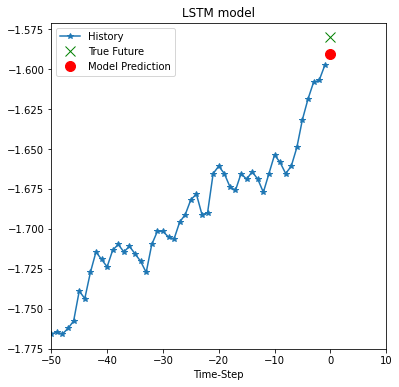

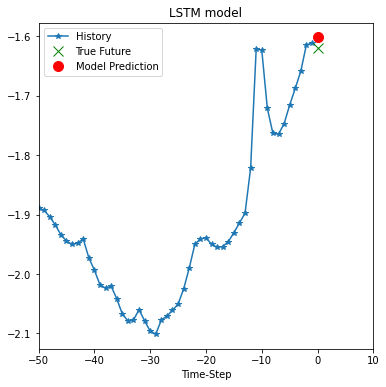

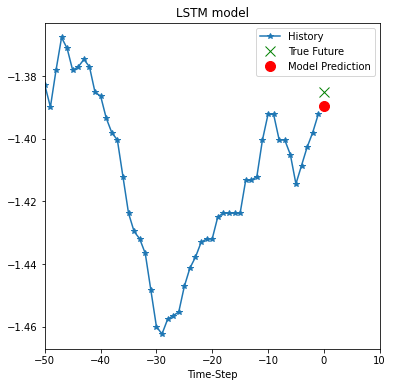

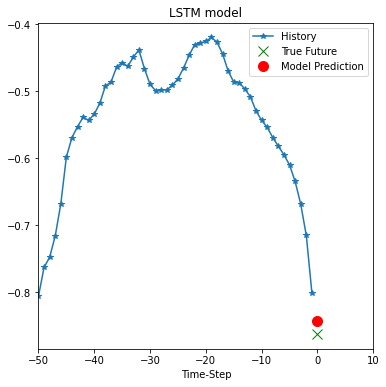

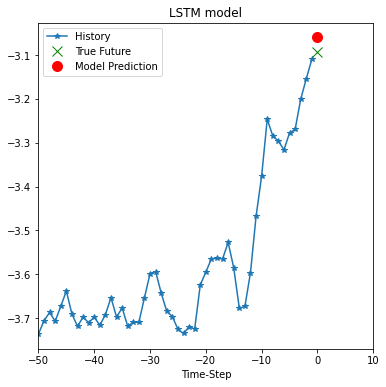

In [259]:
for point, label in test_temp.take(5): # take 5 random inputs from validation data
    plot = show_plot([point[0].numpy(), label[0].numpy(),
                    lstm_model.predict(point)[0]], 0, 'LSTM model')
    plot.show()

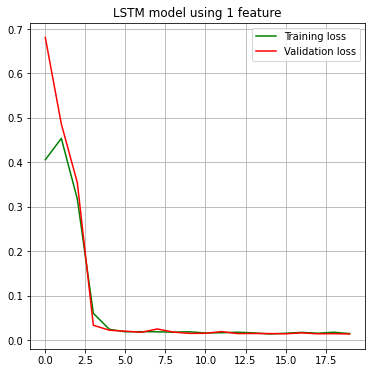

In [263]:
def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))

    plt.figure()
    plt.plot(epochs, loss, 'g', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('LSTM model using 1 feature')
    plt.legend()
    plt.grid()
    plt.show()

plot_history(lstm_model_history)

# Forcasting using 4 features

In [264]:
# prepare data using 4 features
features = ['T (degC)','p (mbar)', 'rho (g/m**3)', "H2OC (mmol/mol)"]

feat_df = df[features]
feat_df.index = df["Date Time"]

feat_df.head()

,T (degC),p (mbar),rho (g/m**3),H2OC (mmol/mol)
Date Time,,,,
01.01.2009 00:10:00,-8.02,996.52,1307.75,3.12
01.01.2009 00:20:00,-8.41,996.57,1309.80,3.03
01.01.2009 00:30:00,-8.51,996.53,1310.24,3.02
01.01.2009 00:40:00,-8.31,996.51,1309.19,3.08
01.01.2009 00:50:00,-8.27,996.51,1309.00,3.09


array([<AxesSubplot:xlabel='Date Time'>, <AxesSubplot:xlabel='Date Time'>,
       <AxesSubplot:xlabel='Date Time'>, <AxesSubplot:xlabel='Date Time'>],
      dtype=object)

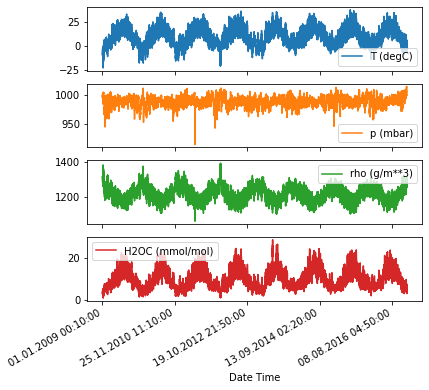

In [265]:
feat_df.plot(subplots=True)

In [266]:
data = feat_df.values
data

array([[  -8.02,  996.52, 1307.75,    3.12],
       [  -8.41,  996.57, 1309.8 ,    3.03],
       [  -8.51,  996.53, 1310.24,    3.02],
       ...,
       [  -3.16,  999.82, 1288.39,    3.28],
       [  -4.23,  999.81, 1293.56,    3.2 ],
       [  -4.82,  999.82, 1296.38,    3.23]])

In [267]:
# standardize
train = 350000
data_mean = data[:train].mean(axis=0)
data_std = data[:train].std(axis=0)
data = (data-data_mean)/(data_std)

In [268]:
data

array([[-2.02968527,  0.92615639,  2.2632811 , -1.51046942],
       [-2.07521719,  0.93221432,  2.31389182, -1.53148518],
       [-2.08689204,  0.92736798,  2.32475461, -1.53382026],
       ...,
       [-1.46228759,  1.32597987,  1.78531842, -1.47310807],
       [-1.58720848,  1.32476829,  1.91295618, -1.49178874],
       [-1.65609009,  1.32597987,  1.98257678, -1.48478349]])

In [269]:
# prepare train and test data 
def dataset(df_x, df_y,start_index, end_index, history, target):    
    data_x = []
    labels_y = []

    start_index = start_index + history
    for i in range(start_index, end_index):
        idx = range(i-history, i)
        data_x.append(df_x[idx])
        labels_y.append(df_y[i+target])
        
    return np.array(data_x), np.array(labels_y)

In [271]:
hist = 100
targ = 0

In [272]:
# Train data
x_train, y_train = dataset(data, data[:,0], 0, train, hist, targ)
# Test data
x_test, y_test = dataset(data, data[:,0], train, data.shape[0] , hist, targ)

In [273]:
print(x_train.shape)
print(y_train.shape)

(349900, 100, 4)
(349900,)


In [274]:
batch = 128
shuff = 10000

train_slices =  tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_slices.cache().shuffle(shuff).batch(batch).repeat()

test_slices =  tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_slices.cache().shuffle(shuff).batch(batch).repeat()

In [275]:
print(train_data)
print(test_data)

<RepeatDataset shapes: ((None, 100, 4), (None,)), types: (tf.float64, tf.float64)>
<RepeatDataset shapes: ((None, 100, 4), (None,)), types: (tf.float64, tf.float64)>


In [276]:
x_train.shape[-2:]

(100, 4)

In [277]:
# LSTM model using 4 featurs
model = Sequential()
model.add(layers.LSTM(32, input_shape=x_train.shape[-2:],return_sequences=True))
model.add(layers.LSTM(8, activation="relu"))
model.add(layers.Dense(1))

model.compile(optimizer='adam', loss='mae')

In [278]:
model_hist = model.fit(train_data, epochs=20, steps_per_epoch=300, validation_data=test_data, validation_steps=100)

Epoch 1/20
300/300 [==============================] - 58s 175ms/step - loss: 0.2454 - val_loss: 0.0617
Epoch 2/20
300/300 [==============================] - 52s 174ms/step - loss: 0.0519 - val_loss: 0.0506
Epoch 3/20
300/300 [==============================] - 51s 170ms/step - loss: 0.0423 - val_loss: 0.0436
Epoch 4/20
300/300 [==============================] - 53s 178ms/step - loss: 0.0437 - val_loss: 0.0362
Epoch 5/20
300/300 [==============================] - 54s 182ms/step - loss: 0.0380 - val_loss: 0.0337
Epoch 6/20
300/300 [==============================] - 53s 175ms/step - loss: 0.0280 - val_loss: 0.0300
Epoch 7/20
300/300 [==============================] - 54s 179ms/step - loss: 0.0300 - val_loss: 0.0282
Epoch 8/20
300/300 [==============================] - 55s 183ms/step - loss: 0.0286 - val_loss: 0.0243
Epoch 9/20
300/300 [==============================] - 54s 179ms/step - loss: 0.0239 - val_loss: 0.0206
Epoch 10/20
300/300 [==============================] - 53s 177ms/step - l

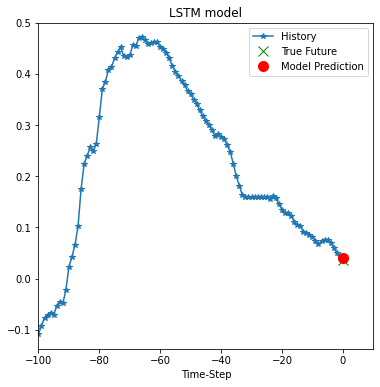

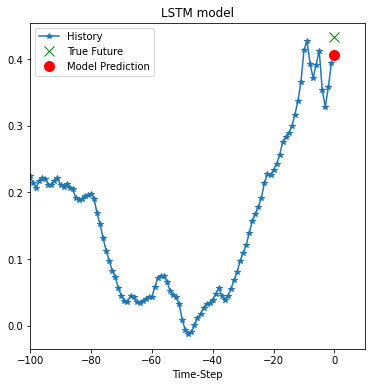

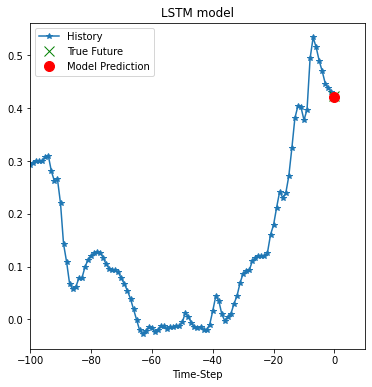

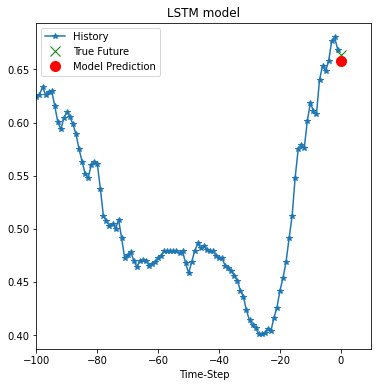

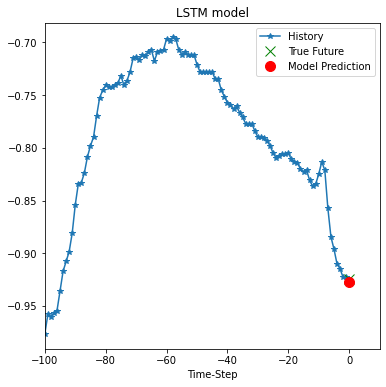

In [279]:
for point, label in test_data.take(5): # take 5 random inputs from validation data
    plot = show_plot([point[0][:,0].numpy(), label[0].numpy(),
                    model.predict(point)[0]], 0, 'LSTM model')
    plot.show()

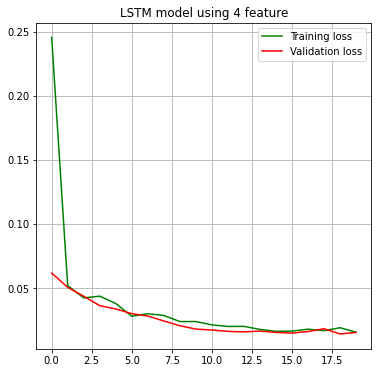

In [280]:
def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))

    plt.figure()
    plt.plot(epochs, loss, 'g', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('LSTM model using 4 feature')
    plt.legend()
    plt.grid()
    plt.show()

plot_history(model_hist)